Осы аптадағы тәжірибелік зертханада сіз бір конфигурацияны қолданып көресіз және бұл желілердің көптеген түрлерінің тіркесімі: деректер терезелері конвульсиядан өтеді, одан кейін жинақталған LSTM, содан кейін жинақталған тығыз қабаттар.

## Қажетті модульдерді импорттаңыз

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Уақыттық қатар деректерін визуалдау

    Параметрлер:
      x (бүтін сандар массиві) - x осіне арналған мәндерді қамтиды
      y (бүтін сандар массиві немесе массивтердің жұбы) - y осіне арналған мәндерді қамтиды
      format (жол) - график сызығының стилі
      start (бүтін сан) - графикте көрсетілетін бірінші уақыт қадамы
      end (бүтін сан) - графикте көрсетілетін соңғы уақыт қадамы
      title (жол) - графиктің тақырыбы
      xlabel (жол) - x осінің атауы
      ylabel (жол) - y осінің атауы
      legend (жолдар тізімі) - графиктің легендасы
    """

    # График фигурасының өлшемдерін орнату
    plt.figure(figsize=(10, 6))

    # Екіден көп қатарды графиктеу қажет пе екенін тексеру
    if type(y) is tuple:

      # y элементтері бойынша цикл жасау
      for y_curr in y:

        # x және ағымдағы y мәндерін графиктеу
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # x және y мәндерін графиктеу
      plt.plot(x[start:end], y[start:end], format)

    # x осінің атауын белгілеу
    plt.xlabel(xlabel)

    # y осінің атауын белгілеу
    plt.ylabel(ylabel)

    # Легенданы орнату
    if legend:
      plt.legend(legend)

    # Тақырыпты орнату
    plt.title(title)

    # Графиктің үстіне тор сызбасын қосу
    plt.grid(True)

    # Экранда графикті көрсету
    plt.show()

## Деректер жинағын жүктеп алыңыз және алдын ала қараңыз

In [ ]:
!wget -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2025-03-10 11:38:23--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2025-03-10 11:38:24 (76.5 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



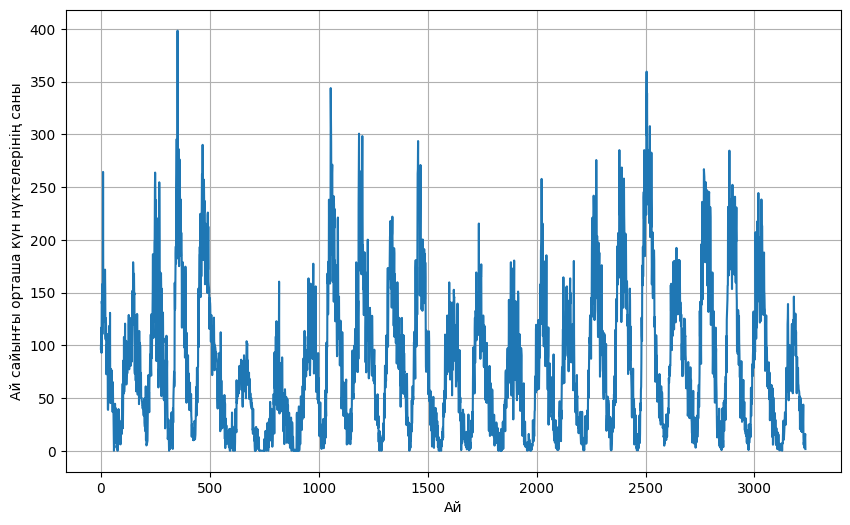

In [ ]:
# Тізімдерді инициализациялау
time_step = []
sunspots = []

# CSV файлын ашу
with open('./Sunspots.csv') as csvfile:

  # Оқырманды инициализациялау
  reader = csv.reader(csvfile, delimiter=',')

  # Бірінші жолды өткізіп жіберу
  next(reader)

  # Әр жолдан уақыт қадамы мен күн нүктелерінің санын тізімге қосу
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Тізімдерді numpy массивтеріне ауыстыру
time = np.array(time_step)
series = np.array(sunspots)

# Деректерді алдын ала қарау
plot_series(time, series, xlabel='Ай', ylabel='Ай сайынғы орташа күн нүктелерінің саны')

## Деректер жиынын бөліңіз

In [ ]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Мүмкіндіктер мен белгілерді дайындаңыз

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Деректер жиынтығының терезелерін құрады

    Параметрлер:
      series (float сандар массиві) - уақыттық қатардың мәндерін қамтиды
      window_size (бүтін сан) - ерекшелікке енгізілетін уақыт қадамдарының саны
      batch_size (бүтін сан) - пакет көлемі
      shuffle_buffer (бүтін сан) - араластыру әдісі үшін қолданылатын буфер көлемі

    Қайтарады:
      dataset (TF Dataset) - уақыттық терезелерді қамтитын TF деректер жиынтығы
    """

    # RNN қабаттарының ерекшелік өлшемі үшін қосымша ось қосу
    series = tf.expand_dims(series, axis=-1)

    # Серия мәндерінен TF деректер жиынтығын жасау
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Деректерді терезеге бөлу, тек көрсетілген өлшемдегі терезелерді таңдау
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Терезелерді бір пакетке біріктіру арқылы тегістеу
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Ерекшеліктер мен белгілерді қамтитын кортеждерді жасау
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Терезелерді араластыру
    dataset = dataset.shuffle(shuffle_buffer)

    # Терезелердің пакеттерін жасау
    dataset = dataset.batch(batch_size)

    # Оқыту үшін деректер жиынтығын оңтайландыру
    dataset = dataset.cache().prefetch(1)

    return dataset

егер сіздің нәтижелеріңіз жақсы болмаса, мұнда параметрлерді өзгертуге және модельдің жақсырақ үйренетінін көруге болады.

In [ ]:
# Параметрлер
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Деректер жиынының терезелерін жасаңыз
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Үлгіні құрастыру

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Үлгінің қысқаша мазмұнын басып шығарыңыз
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Оқу жылдамдығын реттеңіз

оңтайлы оқу жылдамдығын таңдағыңыз келеді.

In [ ]:
# Бастапқы салмақтарды алыңыз
init_weights = model.get_weights()

In [ ]:
# Оқу жылдамдығын реттегішті орнату
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Оптимизаторды инициализациялау
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Оқыту параметрлерін орнату
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Модельді оқыту
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 428.0123 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 327.7161 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 255.7827 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 204.7378 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 166.0542 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135.6609 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 111.9926 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 94.8950 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 82.8349 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 73.8568 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 66.9733 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

(1e-08, 0.001, 0.0, 100.0)

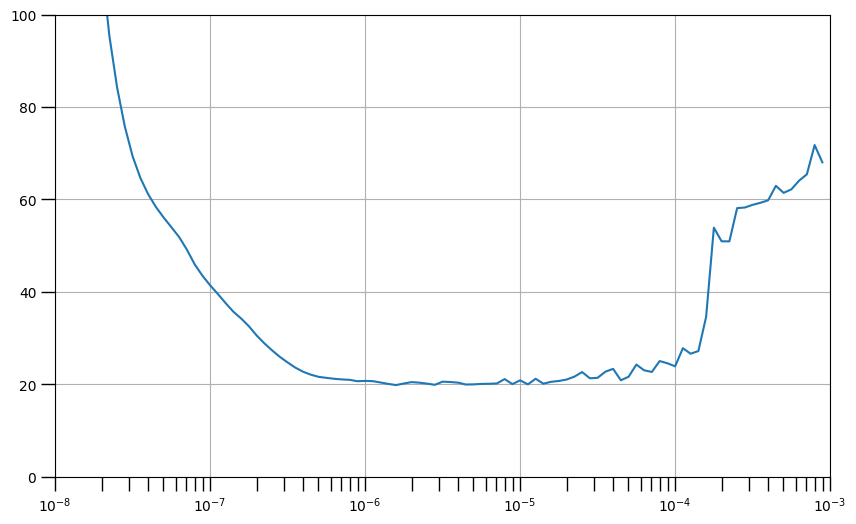

In [ ]:
# Оқу жылдамдығының массивін анықтау
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Фигураның өлшемін орнату
plt.figure(figsize=(10, 6))

# Торды орнату
plt.grid(True)

# Логарифмдік масштабта жоғалту мәнін графиктеу
plt.semilogx(lrs, history.history["loss"])

# Тик белгішелерінің өлшемін ұлғайту
plt.tick_params('both', length=10, width=1, which='both')

# Графиктің шекараларын орнату
plt.axis([1e-8, 1e-3, 0, 100])

## Үлгіні жаттықтыру

Енді үлгіні қалпына келтіруге және үйретуге болады. Ол төмендегі ұяшықта 100 дәуірге орнатылған, бірақ қаласаңыз, оны көбейтуге болады.

In [ ]:
# Keras жасаған күйді қалпына келтіру
tf.keras.backend.clear_session()

# Салмақтарды қалпына келтіру
model.set_weights(init_weights)

In [ ]:
# Оқу жылдамдығын орнату
learning_rate = 8e-7

# Оптимизаторды орнату
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Оқыту параметрлерін орнату
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Модельді оқыту
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 184.2838 - mae: 184.7823
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42.3916 - mae: 42.8887
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.3362 - mae: 33.8328
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.1485 - mae: 26.6427
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23.2561 - mae: 23.7500
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.0784 - mae: 22.5704
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.1803 - mae: 21.6709
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.1670 - mae: 21.6576
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.7934 - mae: 21.2878
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.2350 - mae: 20.7302
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 20.0617 - mae: 20.5539
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.8790 - mae: 20.3712
Epoch 13/10

Сіз жаттығуды визуализациялай аласыз және жоғалту мен MAE әлі де төмендейтінін көре аласыз.

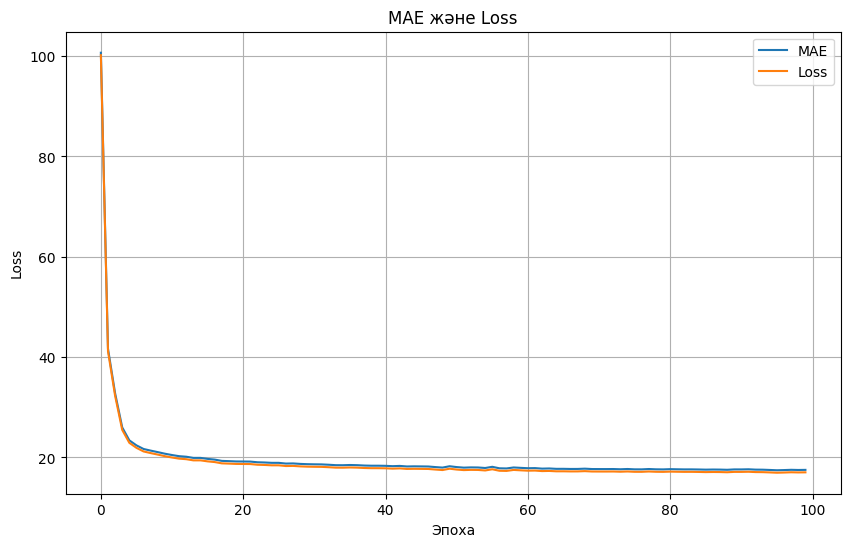

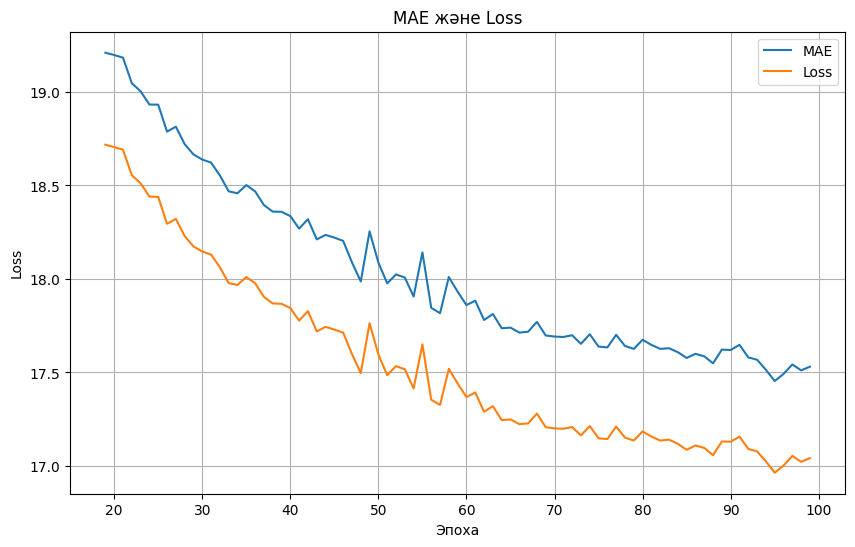

In [ ]:
# Тарих жазбасынан mae және loss мәндерін алу
mae = history.history['mae']
loss = history.history['loss']

# Эпохалардың санын алу
epochs = range(len(loss))

# mae және loss графигін салу
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE және Loss',
    xlabel='Эпоха',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

# Тек соңғы 80% эпохаларды графиктеу
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Үлкейтілген mae және loss графигін салу
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE және Loss',
    xlabel='Эпоха',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

## Модель болжауы

Алдыңғыдай, валидациялық жиынтықтың уақыт диапазоны бойынша болжамдарды алып, метрикаларды есептей аласыз.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Модельді қолданып, деректер терезелеріндегі болжамдарды генерациялайды

    Параметрлер:
      model (TF Keras Model) - деректер терезелерін қабылдайтын модель
      series (float сандар массиві) - уақыттық қатардың мәндерін қамтиды
      window_size (бүтін сан) - терезеге енгізілетін уақыт қадамдарының саны
      batch_size (бүтін сан) - пакет көлемі

    Қайтарады:
      forecast (numpy массиві) - болжамдарды қамтитын массив
    """

    # RNN қабаттарының ерекшелік өлшемі үшін қосымша ось қосу
    series = tf.expand_dims(series, axis=-1)

    # Серия мәндерінен TF деректер жиынтығын жасау
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Деректерді терезеге бөлу, тек көрсетілген өлшемдегі терезелерді таңдау
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Терезелерді бір пакетке біріктіру арқылы тегістеу
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Терезелердің пакеттерін жасау және алдын ала жүктеу
    dataset = dataset.batch(batch_size).prefetch(1)

    # Барлық деректер жиынтығына болжам алу
    forecast = model.predict(dataset, verbose=0)

    return forecast


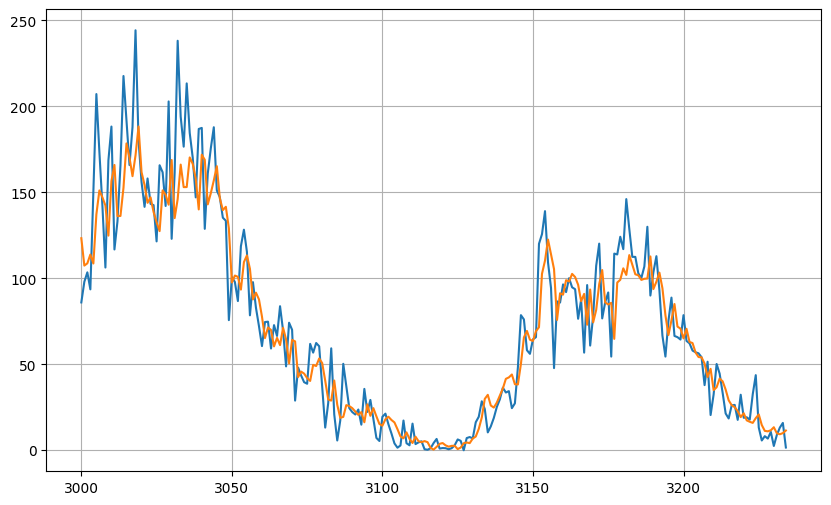

In [ ]:
# Түпнұсқа қатарды қысқарту
forecast_series = series[split_time-window_size:-1]

# Болжамдарды генерациялау үшін көмекші функцияны қолдану
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Бірөлшемді осьті алып тастау
results = forecast.squeeze()

# Нәтижелерді графиктеу
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.191042


## Тапсырма

Уақыт қатарларының деректер жинағын желіден табыңыз немесе оны өзіңіз талдай аласыз, берілген үлгіні пайдаланып уақыт қатарының болжамын жасаңыз